## **Master in Applied Artificial Intelligence**
### **Course: Artificial Intelligence and Automatic Learning**
### Prof. Iván Olmos
#### Tecnológico de Monterrey

### **Project: Results Visualization Activity**
##### **Team members and student IDs:**
*   Victoria Melgarejo Cabrera - A01795030
*   Héctor Alejandro Alvarez Rosas - A01796262
*   Andrea Xcaret Gomez Alfaro - A01796384
*   Mario Guillen De La Torre - A01796701

---


#### **Objective of the Activity:**

To present the results obtained from applying a machine learning model training process on large volumes of data, using visualization tools such as scatter plots, measures of central tendency, heatmaps, and ROC curves.

---

## **1. Construction of the Representative Sample M**

In order to construct a representative sample M of the population P (trips recorded in the city of Chicago), three previously identified characterization variables were used: `payment_group`, `pickup_zone_group`, and `duration_group`. From these, 21 segmentation combinations (Mi) were generated, on which **stratified random sampling** was applied based on the target variable `tip_ratio_group`. This procedure preserved the proportional class distribution within each subset, minimizing the risk of bias injection. Finally, the sample M was built as the **union of all the Mi partitions**, resulting in a balanced and suitable dataset.

**1.1 Environment Setup and Dataset Loading**

In [1]:
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, percentile_approx, min, max, mean, stddev, approx_count_distinct, expr, abs, concat_ws, lit, expr, monotonically_increasing_id, row_number
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pyspark.sql.functions import hour, dayofweek, unix_timestamp, when
from pyspark.sql.functions import to_timestamp, hour, dayofweek
from pyspark.sql import functions as F
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import broadcast
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
from functools import reduce
from pyspark.sql.window import Window
import random
from sklearn.metrics import classification_report, confusion_matrix
import gc
from pyspark.sql.window import Window
from functools import reduce
from pyspark import StorageLevel
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [2]:
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

spark = (SparkSession.builder
  .master("local[*]")
  .config("spark.driver.bindAddress","127.0.0.1")
  .config("spark.driver.host","127.0.0.1")
  .config("spark.ui.enabled","false")
  .config("spark.python.use.daemon","false")
  .config("spark.pyspark.python", sys.executable)
  .config("spark.pyspark.driver.python", sys.executable)
  .getOrCreate())
spark.sparkContext.setLogLevel("WARN")

In [3]:
print("range count:", spark.range(10).count())  # JVM-only
print("RDD map:", spark.sparkContext.parallelize([1,2,3,4], 2)
                         .map(lambda x: x+1).collect())  # spawns Python workers

range count: 10
RDD map: [2, 3, 4, 5]


In [4]:
filename = "Taxi_Trips__2024-__20250426.csv"
local_path = f"/C:/Users/mario/Maestria/Grandes Cantidades de Datos/ActividadesOrden/{filename}"
dftaxytrips = spark.read.csv(local_path, header=True, inferSchema=True)

In [5]:
print("Number of records:", dftaxytrips.count())
print("Number of columns:", len(dftaxytrips.columns))

Number of records: 7917844
Number of columns: 23


**1.2 Transformation, Grouping, and Enrichment of Variables**

In [6]:
# Trip Start Timestamp is Timestamp type
dftaxytrips = dftaxytrips.withColumn(
    "trip_start_ts",
    to_timestamp(col("Trip Start Timestamp"), "MM/dd/yyyy hh:mm:ss a")
)

# Time of day
dftaxytrips = dftaxytrips.withColumn("trip_hour", hour(col("trip_start_ts")))

# Week day (1 = Sunday, 7 = Saturday)
dftaxytrips = dftaxytrips.withColumn("trip_day_of_week", dayofweek(col("trip_start_ts")))

# Trip duration in minutes
dftaxytrips = dftaxytrips.withColumn("duration_minutes", col("Trip Seconds") / 60)

# Tip/Fare ratio
dftaxytrips = dftaxytrips.withColumn("tip_ratio",
    when(col("Fare") > 0, col("Tips") / col("Fare")).otherwise(0))

# Tip/Trip Miles ratio
dftaxytrips = dftaxytrips.withColumn("tip_per_mile",
    when(col("Trip Miles") > 0, col("Tips") / col("Trip Miles")).otherwise(0))

# Payment method group
dftaxytrips = dftaxytrips.withColumn("payment_group",
    when(col("Payment Type") == "Credit Card", "Credit Card")
    .when(col("Payment Type") == "Cash", "Cash")
    .when(col("Payment Type") == "Mobile", "Mobile")
    .otherwise("Other"))

# Company group
dftaxytrips = dftaxytrips.withColumn("company_group",
    when(col("Company") == "Flash Cab", "Flash Cab")
    .when(col("Company") == "Taxi Affiliation Services", "Taxi Affiliation")
    .when(col("Company") == "Taxicab Insurance Agency Llc", "Insurance Agency")
    .when(col("Company") == "Sun Taxi", "Sun Taxi")
    .when(col("Company") == "City Service", "City Service")
    .when(col("Company") == "Chicago Independents", "Chicago Independents")
    .otherwise("Other"))

# Origin Zone Group
dftaxytrips = dftaxytrips.withColumn("pickup_zone_group",
    when(col("Pickup Community Area") == 76, 76)
    .when(col("Pickup Community Area") == 8, 8)
    .when(col("Pickup Community Area") == 32, 32)
    .otherwise("Other"))

# Group Destination Zone
dftaxytrips = dftaxytrips.withColumn("dropoff_zone_group",
    when(col("Dropoff Community Area") == 8, 8)
    .when(col("Dropoff Community Area") == 32, 32)
    .when(col("Dropoff Community Area") == 28, 28)
    .when(col("Dropoff Community Area") == 76, 76)
    .otherwise("Other"))

# Rename certain columns
dftaxytrips = dftaxytrips.withColumnRenamed("Trip ID", "trip_id")
dftaxytrips = dftaxytrips.withColumnRenamed("Trip Miles", "trip_miles")

In [7]:
# Based on the analysis carried out in the previous project, it was decided to use percentiles to create segmentation and generate these four variables:
# Trip duration (in minutes)
dftaxytrips = dftaxytrips.withColumn(
    "duration_group",
    (
        when(col("duration_minutes") <= 10.0, "Flash Riders")           # very short trips, high turnover
        .when(col("duration_minutes") <= 23.2, "Urban Cruisers")        # typical city trips
        .otherwise("Long-Haul Nomads")                                  # long trips, possibly between distant districts
    )
)

# Tip per mile
dftaxytrips = dftaxytrips.withColumn(
    "tip_per_mile_group",
    (
        when(col("tip_per_mile") <= 0.0, "Non-Tippers")                 # users who don’t leave a tip
        .when(col("tip_per_mile") <= 0.58, "Appreciative Riders")       # moderate tips relative to distance
        .otherwise("Tip Enthusiasts")                                   # generous travelers per mile traveled
    )
)

# Tip-to-fare ratio
dftaxytrips = dftaxytrips.withColumn(
    "tip_ratio_group",
    (
        when(col("tip_ratio") <= 0.0, "Flat Fare Clients")              # no tip
        .when(col("tip_ratio") <= 0.21, "Grateful Givers")              # moderate tip as a percentage of the total fare
        .otherwise("High-Spirit Donors")                                # users with a high level of tipping appreciation
    )
)


# Trip distance (in miles)
dftaxytrips = dftaxytrips.withColumn(
    "trip_miles_group",
    (
        when(col("trip_miles") <= 1.4, "Neighborhood Navigators")       # very short distances within the zone
        .when(col("trip_miles") <= 9.4, "City Explorers")               # average distances within the city
        .otherwise("Wide-Radius Riders")                                # long trips, possibly airport or suburban transfers
    )
)

In [8]:
# Columns to Select
selected_columns = [
    "trip_id",
    "trip_hour",
    "trip_day_of_week",
    "duration_minutes",
    "trip_miles",
    "tip_ratio",
    "tip_per_mile",
    "payment_group",
    "company_group",
    "pickup_zone_group",
    "dropoff_zone_group",
    "duration_group",
    "tip_per_mile_group",
    "tip_ratio_group",
    "trip_miles_group"
]

# Select specific columns
dftaxytrips_selected = dftaxytrips.select(*selected_columns)
dftaxytrips_selected.limit(5).toPandas()

,trip_id,trip_hour,trip_day_of_week,duration_minutes,trip_miles,tip_ratio,tip_per_mile,payment_group,company_group,pickup_zone_group,dropoff_zone_group,duration_group,tip_per_mile_group,tip_ratio_group,trip_miles_group
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,17,6,67.516667,17.12,0.219780,0.584112,Credit Card,Flash Cab,76,32,Long-Haul Nomads,Tip Enthusiasts,High-Spirit Donors,Wide-Radius Riders
1,000072ee076c9038868e239ca54185eb43959db0,14,1,29.150000,12.70,0.000000,0.000000,Cash,Flash Cab,Other,Other,Long-Haul Nomads,Non-Tippers,Flat Fare Clients,Wide-Radius Riders
2,000074019d598c2b1d6e77fbae79e40b0461a2fc,9,6,8.616667,3.39,0.254812,0.820059,Mobile,Insurance Agency,Other,8,Flash Riders,Tip Enthusiasts,High-Spirit Donors,City Explorers
3,00007572c5f92e2ff067e6f838a5ad74e83665d3,8,2,34.166667,15.06,0.288153,0.750996,Credit Card,Other,76,Other,Long-Haul Nomads,Tip Enthusiasts,High-Spirit Donors,Wide-Radius Riders
4,00007c3e7546e2c7d15168586943a9c22c3856cf,19,5,16.733333,1.18,0.233375,3.152542,Mobile,Other,32,32,Urban Cruisers,Tip Enthusiasts,High-Spirit Donors,Neighborhood Navigators



**1.3 Partitioning Rules**

Since our objective focuses on analyzing tips in Chicago taxi trips and predicting relevant patterns, we considered the following three variables:

*    **`payment_group`:** Grouping of the payment method into Credit Card, Cash, Mobile, and Other. This is considered key due to the strong relationship between card payments and the tips given.

*    **`pickup_zone_group`:** Grouping of pickup zones, with specific areas (76, 8, 32) and an "Other" group that includes the remaining zones. This serves as a proxy for socioeconomic or commercial location.

*    **`duration_group`:** Classification of trip duration: Flash Riders (≤10 min), Urban Cruisers (10–23.2 min), Long-Haul Nomads (>23.2 min). This captures the intensity and context of the trip.

Additionally, we consider that these variables capture key behavioral factors related to a passenger’s decision to leave a tip.

In [9]:
def categorical_summary(df, column):
    # Total count of non-null values
    count = df.filter(F.col(column).isNotNull()).count()

    # Count of distinct values
    unique = df.select(column).distinct().count()

    # Most frequent value and its frequency
    top_row = (df.groupBy(column)
                 .agg(F.count("*").alias("freq"))
                 .orderBy(F.desc("freq"))
                 .first())

    top = top_row[column] if top_row else None
    freq = top_row["freq"] if top_row else 0

    # Create a summary dictionary
    summary = {
        "count": count,
        "unique": unique,
        "top": top,
        "freq": freq
    }

    return summary

In [10]:
for colu in ["payment_group", "pickup_zone_group", "duration_group"]:
    print(f'{colu} - {categorical_summary(dftaxytrips_selected, colu)}')

payment_group - {'count': 7917844, 'unique': 4, 'top': 'Credit Card', 'freq': 3066154}
pickup_zone_group - {'count': 7917844, 'unique': 4, 'top': 'Other', 'freq': 3322581}
duration_group - {'count': 7917844, 'unique': 3, 'top': 'Long-Haul Nomads', 'freq': 2706495}


In [11]:
# Group by the key variables
partition_counts = dftaxytrips_selected.groupBy(
    "payment_group", "pickup_zone_group", "duration_group"
).agg(count("*").alias("count"))

# Calculate overall total
total_count = dftaxytrips_selected.count()

# Add proportion per combination
partition_counts = partition_counts.withColumn(
    "proportion", col("count") / total_count
)

# Sort by the most representative
partition_counts.orderBy(col("proportion").desc()).limit(60).toPandas()

,payment_group,pickup_zone_group,duration_group,count,proportion
0,Credit Card,76,Long-Haul Nomads,932993,0.117834
1,Other,Other,Urban Cruisers,492887,0.062250
2,Other,Other,Long-Haul Nomads,471644,0.059567
3,Cash,Other,Flash Riders,453456,0.057270
4,Cash,8,Flash Riders,306484,0.038708
5,Credit Card,Other,Flash Riders,297684,0.037597
6,Credit Card,32,Flash Riders,291907,0.036867
7,Credit Card,8,Flash Riders,276498,0.034921
8,Cash,Other,Urban Cruisers,274870,0.034715
9,Mobile,Other,Urban Cruisers,270757,0.034196


During the characterization stage of the partitions generated from combinations of categorical variables (payment_group, pickup_zone_group, and duration_group), a total of 48 unique partitions were identified. However, not all of these partitions have a significant proportion relative to the total number of observations in the dataset. As shown in the table above, several of these combinations represent less than 2% of the total population, and some even less than 1%.

From a statistical and computational standpoint, keeping all the original partitions could result in an excessively granular segmentation, which:

-    Increases variance in stratified sampling

-    Reduces the stability of estimators in subsequent models

-    Compromises computational efficiency in big data scenarios

Therefore, a consolidation strategy is proposed: group all partitions whose proportion is less than 2% into a residual category. This approach preserves the overall structure of the population while stabilizing the statistical behavior of the smaller partitions.

In [12]:
# Label combinations greater than 2%
significant_combinations = partition_counts.filter(col("proportion") > 0.02)

# Create combination name
significant_combinations = significant_combinations.withColumn(
    "StrataGrouping", concat_ws("_", "payment_group", "pickup_zone_group", "duration_group")
)

# Join with the main dataset to assign the name or 'Other'
dftaxytrips_with_strata = dftaxytrips_selected.join(
    significant_combinations.select(
        "payment_group", "pickup_zone_group", "duration_group", "StrataGrouping"
    ),
    on=["payment_group", "pickup_zone_group", "duration_group"],
    how="left"
)

# Replace nulls with "Other"
dftaxytrips_with_strata = dftaxytrips_with_strata.withColumn(
    "StrataGrouping",
    when(col("StrataGrouping").isNull(), lit("Other")).otherwise(col("StrataGrouping"))
)

In [13]:
# Count observations per group
grouped_partition_counts = dftaxytrips_with_strata.groupBy(
    "StrataGrouping"
).agg(count("*").alias("count"))

# Calculate the proportion of each group relative to the total dataset
grouped_partition_counts = grouped_partition_counts.withColumn(
    "proportion", col("count") / total_count
)

# Sort in descending order by proportion of observations per group
grouped_partition_counts.orderBy(col("proportion").desc()).limit(30).toPandas()

,StrataGrouping,count,proportion
0,Other,1723968,0.217732
1,Credit Card_76_Long-Haul Nomads,932993,0.117834
2,Other_Other_Urban Cruisers,492887,0.062250
3,Other_Other_Long-Haul Nomads,471644,0.059567
4,Cash_Other_Flash Riders,453456,0.057270
5,Cash_8_Flash Riders,306484,0.038708
6,Credit Card_Other_Flash Riders,297684,0.037597
7,Credit Card_32_Flash Riders,291907,0.036867
8,Credit Card_8_Flash Riders,276498,0.034921
9,Cash_Other_Urban Cruisers,274870,0.034715


**1.4 Sampling Technique**

A **stratified random sampling** was applied using **tip_ratio_group** within each of the 21 partitions obtained from the characterization variables. This technique preserves the proportional distribution of classes within each subpopulation, reducing bias and ensuring a representative sample for supervised learning tasks in multiclass classification problems. The resulting sample is more robust for training predictive models and reduces the risk of overfitting to majority classes.

For our analysis, the fraction of the target class is considered as follows:

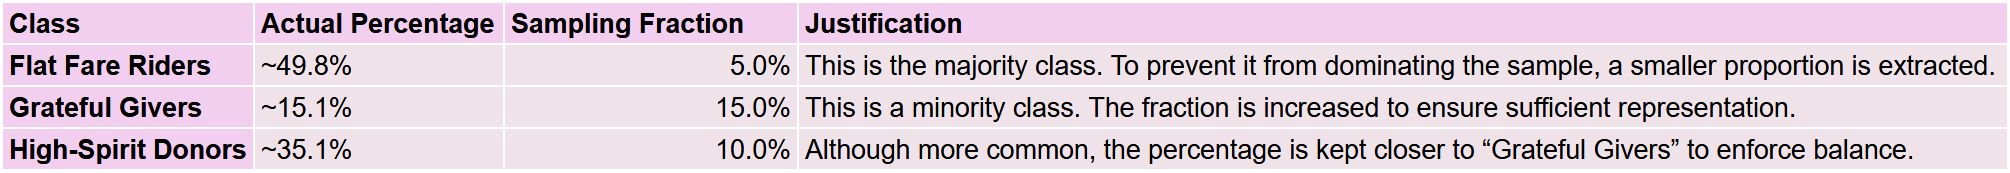

In [14]:
# Obtain the new stratification groups
strata_groups = dftaxytrips_with_strata.select("StrataGrouping").distinct().collect()

# Suggested sampling fractions per class
fractions = {
    "Flat Fare Clients": 0.05,
    "Grateful Givers": 0.15,
    "High-Spirit Donors": 0.10
}

# List to store the sampled dataframes by partition
sampled_partitions = []

# Apply sampling for each combination
for row in strata_groups:
    strata_value = row["StrataGrouping"]

    df_partition = dftaxytrips_with_strata.filter(col("StrataGrouping") == strata_value)

    # Only sample if there are records in the partition
    if df_partition.count() > 0:
        sampled = df_partition.sampleBy("tip_ratio_group", fractions, seed=42)
        sampled_partitions.append(sampled)

# Merge all samples into a single sample M
dftaxytrips_m = reduce(DataFrame.unionAll, sampled_partitions)

In [15]:
# Verify distribution by records and columns
print("Number of records:", dftaxytrips_m.count())
print("Number of columns:", len(dftaxytrips_m.columns))

Number of records: 654487
Number of columns: 16


In [16]:
# Verify final class distribution
print("Class distribution:")
dftaxytrips_m.groupBy("tip_ratio_group").count().toPandas()

Class distribution:


,tip_ratio_group,count
0,Flat Fare Clients,197234
1,Grateful Givers,179573
2,High-Spirit Donors,277680


In [17]:
numeric_cols = ["duration_minutes", "trip_miles"]
cat_cols = ["trip_month"]

## **2. Data Processing in Sample M**

In order to guarantee the quality and consistency of the analysis, a set of systematic data preparation procedures was developed before applying machine learning algorithms. This process included the identification of subsets of relevant variables for each type of analytical task (supervised classification and unsupervised clustering), followed by the handling of null values, the detection and mitigation of outliers, and the transformation of categorical variables through appropriate encoding techniques.

**2.1 Dataframes Identified for Each Type of Algorithm**

In [18]:
# Copy of the dataframe
dftaxytrips_m = dftaxytrips_m.cache()

# Force evaluation to materialize the cache
dftaxytrips_m.count()

655094

In [19]:
# Columns to Select for the Classification Algorithm
columnas_m1 = [
    "trip_id",
    "trip_hour",
    "trip_day_of_week",
    "duration_minutes",
    "trip_miles",
    #"tip_ratio", // Removed to avoid correlation with the target.
    "tip_per_mile",
    "payment_group",
    "company_group",
    "pickup_zone_group",
    "dropoff_zone_group",
    "tip_ratio_group"
]

# Selection of specific columns
dftaxytrips_clasificacion = dftaxytrips_m.select(*columnas_m1)

In [20]:
# Columns to Select for the Clustering Algorithm
columnas_m2 = [
    "trip_id",
    "trip_hour",
    "trip_day_of_week",
    "duration_minutes",
    "trip_miles",
    "tip_ratio",
    "tip_per_mile",
    "payment_group",
    "company_group",
    "pickup_zone_group",
    "dropoff_zone_group"
]

# Selection of specific columns
dftaxytrips_clustering = dftaxytrips_m.select(*columnas_m2)

**2.2 Analysis of Null Values and Median Imputation**

In [21]:
# 1) Review of null values
#    Classification case
null_summary = dftaxytrips_clasificacion.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c)
    for c in dftaxytrips_clasificacion.columns
])
null_summary.toPandas()

,trip_id,trip_hour,trip_day_of_week,duration_minutes,trip_miles,tip_per_mile,payment_group,company_group,pickup_zone_group,dropoff_zone_group,tip_ratio_group
0,0,0,0,72,6,950,0,0,0,0,0


In [22]:
#    Clustering case
null_summary = dftaxytrips_clustering.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c)
    for c in dftaxytrips_clustering.columns
])
null_summary.show()

+-------+---------+----------------+----------------+----------+---------+------------+-------------+-------------+-----------------+------------------+
|trip_id|trip_hour|trip_day_of_week|duration_minutes|trip_miles|tip_ratio|tip_per_mile|payment_group|company_group|pickup_zone_group|dropoff_zone_group|
+-------+---------+----------------+----------------+----------+---------+------------+-------------+-------------+-----------------+------------------+
|      0|        0|               0|              72|         6|        0|         950|            0|            0|                0|                 0|
+-------+---------+----------------+----------------+----------+---------+------------+-------------+-------------+-----------------+------------------+



In [23]:
# Median imputation
# Numerical columns to impute with the median
#    Classification case
num_cols = ["duration_minutes", "trip_miles", "tip_per_mile"]

# Calculate the median for each numerical column
medians = {
    col_name: dftaxytrips_clasificacion.select(percentile_approx(col_name, 0.5)).first()[0]
    for col_name in num_cols
}

# Impute nulls with the median
dftaxytrips_clasificacion = dftaxytrips_clasificacion.fillna(medians)

In [24]:
# Numerical columns to impute with the median
#    Clustering case
num_cols = ["duration_minutes", "trip_miles", "tip_per_mile"]

# Calculate the median for each numerical column
medians = {
    col_name: dftaxytrips_clustering.select(percentile_approx(col_name, 0.5)).first()[0]
    for col_name in num_cols
}

# Impute nulls with the median
dftaxytrips_clustering = dftaxytrips_clustering.fillna(medians)

**2.3 Treatment of Outliers Using the Interquartile Range (IQR)**

In [25]:
# Case Classification
# Filter outliers for each variable
for col_name in num_cols:
    # Getting Q1 and Q3
    q1, q3 = dftaxytrips_clasificacion.approxQuantile(col_name, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Apply filter to remove outliers
    dftaxytrips_clasificacion = dftaxytrips_clasificacion.filter(
        (col(col_name) >= lower_bound) & (col(col_name) <= upper_bound)
    )

In [26]:
# Case Clustering
# Filter outliers for each variable
for col_name in num_cols:
    # Get Q1 and Q3
    q1, q3 = dftaxytrips_clustering.approxQuantile(col_name, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

     # Apply filter to remove outliers
    dftaxytrips_clustering = dftaxytrips_clustering.filter(
        (col(col_name) >= lower_bound) & (col(col_name) <= upper_bound)
    )

**2.4 One Hot Encoding for Supervised Learning**

In [27]:
# 2) Conversion of data type and OHE encoding for the Classification Algorithm
cat_vars = [
    "trip_hour", "trip_day_of_week",
    "payment_group", "company_group",
    "pickup_zone_group", "dropoff_zone_group"
]

# Verify that values are strings
for var in cat_vars:
    dftaxytrips_clasificacion = dftaxytrips_clasificacion.withColumn(var, col(var).cast("string"))

# Create indexers and encoders
indexers = [
    StringIndexer(inputCol=colname, outputCol=colname + "_idx", handleInvalid="keep")
    for colname in cat_vars
]

encoders = [
    OneHotEncoder(inputCol=colname + "_idx", outputCol=colname + "_vec")
    for colname in cat_vars
]

# Numerical variables
num_vars = ["duration_minutes", "trip_miles", "tip_per_mile"]

# Build the final feature vector
assembler_inputs = [col + "_vec" for col in cat_vars] + num_vars
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Complete pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Transform the DataFrame
model_pipeline = pipeline.fit(dftaxytrips_clasificacion)
df_encoded = model_pipeline.transform(dftaxytrips_clasificacion)

**Indexing of Categorical Variables for Unsupervised Learning**

In [28]:
# 2) Conversion of data type and Indexing for the Clustering Algorithm
# Categorical variables with text
cat_vars = [
    "payment_group", "company_group",
    "pickup_zone_group", "dropoff_zone_group"
]

# Numerical variables
num_vars = [
    "trip_hour", "trip_day_of_week",
    "duration_minutes", "trip_miles", "tip_per_mile"
]

# Index only the necessary categorical variables
indexers = [
    StringIndexer(inputCol=colname, outputCol=colname + "_idx", handleInvalid="keep")
    for colname in cat_vars
]

# Build final list of columns to assemble
features_input = [col + "_idx" for col in cat_vars] + num_vars

# Assembler
assembler = VectorAssembler(inputCols=features_input, outputCol="features")

# Pipeline
pipeline = Pipeline(stages=indexers + [assembler])
df_clustering = pipeline.fit(dftaxytrips_clustering).transform(dftaxytrips_clustering)

## **3. Definition and Justification of K-Fold Cross Validation**

To obtain a robust evaluation of the performance of the machine learning model selected in Activity 4 (the one that gave us the best preliminary results), it is crucial not to rely on a single random split of the data into training and testing sets. A single split can lead to a performance estimate that is either too optimistic or too pessimistic, depending on which data ends up in each set.

To mitigate this problem and obtain a more reliable measure of our model’s generalization ability, we will apply the **K-Fold Cross-Validation** technique.

**3.1 What is K-Fold Cross-Validation?**

This method consists of dividing the entire dataset into **‘k’ subsets (folds)** of approximately equal size. The evaluation process is then repeated ‘k’ times (or ‘k’ iterations). In each iteration:

1.  **One fold** is selected to act as the **testing set** for that iteration.
2.  The remaining **‘k-1’ folds** are combined to form the **training set**.
3.  The model is trained using the training set.
4.  The performance of the trained model is evaluated using the testing set.

This cycle repeats until each of the ‘k’ folds has been used as a testing set exactly once. In the end, we obtain ‘k’ different performance metrics (one for each iteration).

**3.2 Justification for Choosing k = 5**

We have decided to use **k = 5** for our cross-validation. This choice is based on a balance between several factors:

*   **Computational Cost:** A value of k=5 requires training the model 5 times. This is manageable for our dataset and resources, unlike larger values of ‘k’ (such as k=10 or Leave-One-Out Cross-Validation where k equals the number of samples), which would significantly increase processing time.
*   **Reliability of the Estimate:** With 5 folds, the model is evaluated on 5 different subsets of 20% of the data (if the dataset is divided evenly). This provides a much more reliable and stable performance estimate than a single split (e.g., 80/20), as it reduces dependence on any one particular partition of the data.
*   **Measurement of Variability:** Obtaining 5 performance results allows us to calculate statistics such as the mean and standard deviation of the metrics. The standard deviation is a direct measure of the variability of the model’s performance across different data subsets, which is a key objective of this activity.

We consider k=5 to be a good compromise for obtaining a robust estimate of performance and its variability without incurring excessive computational cost.

**3.3 Ensuring Representativeness**

To ensure that each of the 5 folds is as representative as possible of the full dataset, we will use the standard implementation of `KFold` from the Scikit-learn library. When configured with `shuffle=True` before splitting, this implementation helps distribute the dataset’s characteristics more evenly among the folds. Although no explicit stratification is applied (which is more common in classification problems to preserve class proportions), for a regression problem like price prediction, random shuffling before splitting is a standard practice that favors representativeness of each subset. Each fold thus acts as a small “sample” of the overall dataset.

In the next section, we will present the code that implements the generation of these 5 folds, thereby preparing the data for the iterative training and evaluation phase.

## **4. Construction of K-Folds and Cross-Validation with Stratification**

**4.1 Preparation of the Target Variable**

In [29]:
label_indexer = StringIndexer(inputCol="tip_ratio_group", outputCol="label")
indexer_model = label_indexer.fit(df_encoded)
df_final = indexer_model.transform(df_encoded)
df_final = df_final.withColumn("label", col("label").cast("double"))

print(indexer_model.labels) # 0 High-Spirit Donors, 1 Flat Fare Clients, 2 Grateful Givers

['High-Spirit Donors', 'Flat Fare Clients', 'Grateful Givers']


**4.2 Initialization of Evaluation Metrics**

In [30]:
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

## **5. Training the Supervised Model with K-Fold Cross-Validation**

**5.1 RandomForestClassifier with Cross-Validation**

Based on the results obtained in Activity 4, where the Random Forest Classifier model showed promising performance for the task of tip-behavior classification, we proceed to evaluate it more robustly using K-Fold cross-validation.

**5.2 Preparation of Stratified Folds**

To implement cross-validation with k=5, we first assign a fold identifier to each record in our dataset. We use PySpark’s `row_number()` function, ordered by a monotonically increasing ID (to ensure deterministic ordering), and then apply the modulo (`%`) operator with `k=5` to assign each row a `fold_id` between 0 and 4. This process distributes the records evenly across the 5 folds.

In the training phase, we iterate 5 times. In each iteration `i`, we select the records with `fold_id == i` as the testing set, and the records with `fold_id != i` as the training set. This method ensures that each record is used once as testing and in the remaining iterations as training. 

In [31]:
# Number of folds
k = 5

# Initial stratification with rotating index by random ID
df_stratified = df_final.withColumn(
    "row_id", F.row_number().over(Window.orderBy(F.monotonically_increasing_id()))
)

df_stratified = df_stratified.withColumn(
    "fold_id", ((F.col("row_id") - F.lit(1)) % F.lit(k)).cast("int")
)

df_stratified = df_stratified.persist(StorageLevel.DISK_ONLY)

**5.3 Initialization of the Model and Evaluation Metrics**

In [32]:
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

**5.4 Cross-Validation with RandomForestClassifier (per fold)**

In [33]:
def print_heatmap(cm, labels):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.tight_layout()
    plt.show()

def plot_multiclass_roc_all_folds(fold_roc_data, class_labels):
    """
    Plot an ROC curve per class, with the curves from all folds
    """
    n_classes = len(class_labels)
    fig, axes = plt.subplots(1, n_classes, figsize=(6 * n_classes, 5), sharey=True)

    if n_classes == 1:
        axes = [axes]  # Ensure iterablility

    for idx, class_val in enumerate(class_labels):
        ax = axes[idx]
        for entry in fold_roc_data:
            if entry["class"] == class_val:
                ax.plot(entry["fpr"], entry["tpr"],
                        label=f'Fold {entry["fold"]} (AUC={entry["auc"]:.2f})',
                        lw=1.5)

        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - Clase {class_val}')
        ax.legend(loc='lower right')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def plot_multiclass_auc_bars(fold_auc_scores):
    import pandas as pd

    df_auc = pd.DataFrame(fold_auc_scores)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_auc, x="fold", y="auc", hue="class", palette="Set2")
    plt.ylim(0.0, 1.05)
    plt.ylabel("AUC")
    plt.xlabel("Fold")
    plt.title("AUC by Class and Fold")
    plt.legend(title="Class", loc='upper right')
    plt.tight_layout()
    plt.show()


🔄 Fold 1/5
  ✅ Accuracy:  0.7832
  ✅ Precision: 0.7902
  ✅ Recall:    0.7832
  ✅ F1-Score:  0.7713

 Confusion matrix:
[[40692   826  2419]
 [  680 34705  3087]
 [16745  1332 15220]]


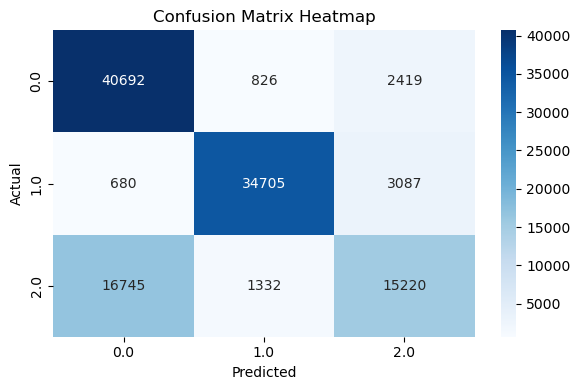


🔄 Fold 2/5
  ✅ Accuracy:  0.7814
  ✅ Precision: 0.7869
  ✅ Recall:    0.7814
  ✅ F1-Score:  0.7697

 Confusion matrix:
[[40844   789  2721]
 [  692 34674  3103]
 [16726  1263 14894]]


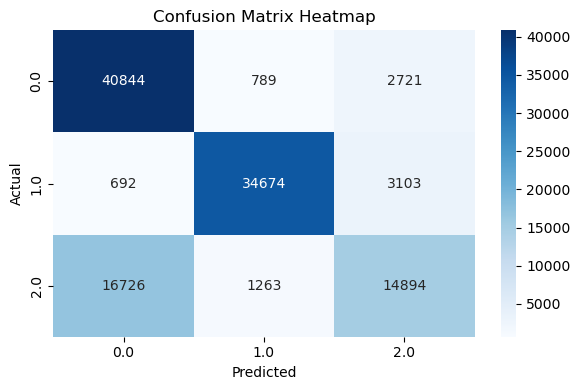


🔄 Fold 3/5
  ✅ Accuracy:  0.7633
  ✅ Precision: 0.7848
  ✅ Recall:    0.7633
  ✅ F1-Score:  0.7414

 Confusion matrix:
[[40891  1575  1598]
 [ 1723 35364  1311]
 [19172  2014 12058]]


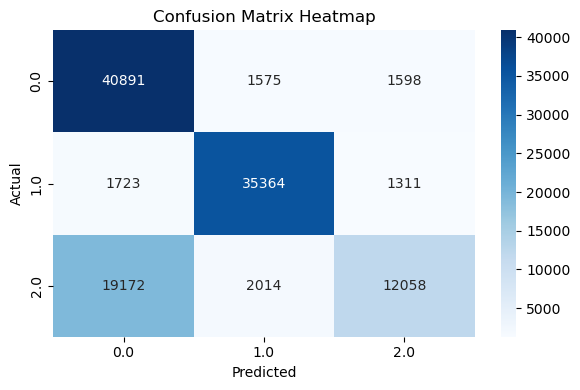


🔄 Fold 4/5
  ✅ Accuracy:  0.7811
  ✅ Precision: 0.7916
  ✅ Recall:    0.7811
  ✅ F1-Score:  0.7650

 Confusion matrix:
[[40809   937  2455]
 [  844 35724  1758]
 [17708  1623 13848]]


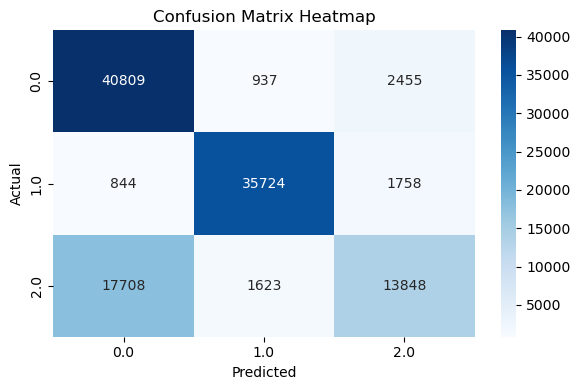


🔄 Fold 5/5
  ✅ Accuracy:  0.7796
  ✅ Precision: 0.7890
  ✅ Recall:    0.7796
  ✅ F1-Score:  0.7645

 Confusion matrix:
[[40435   902  2750]
 [  869 35718  1816]
 [17671  1493 14052]]


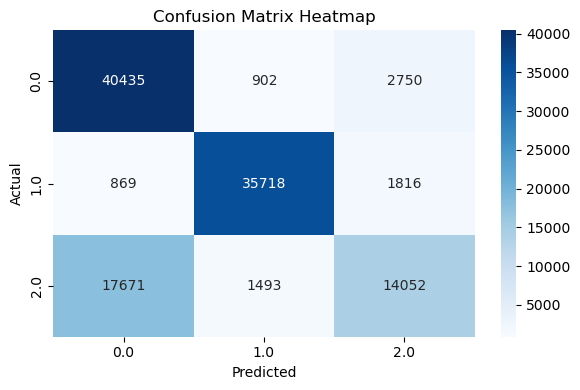

In [34]:
results = []
average_confusion_matrix = []
confusion_matrix_labels = []

fold_roc_data = []       # Save ROC curves per class and fold
fold_auc_scores = []     # Save AUCs per class and fold
class_labels = None      # Defined dynamically

for i in range(k):
    print(f"\n🔄 Fold {i+1}/{k}")

    try:
        # Separate test and train folds
        test_df = df_stratified.filter(F.col("fold_id") == i).select("features", "label")
        train_df = df_stratified.filter(F.col("fold_id") != i).select("features", "label")

        label_fractions = df_stratified \
            .filter(F.col("fold_id") != i) \
            .select("label") \
            .distinct() \
            .rdd \
            .map(lambda row: (row["label"], 0.3)) \
            .collectAsMap()
     
        # Apply stratified sampling
        train_df = df_stratified \
            .filter(F.col("fold_id") != i) \
            .sampleBy("label", fractions=label_fractions, seed=42) \
            .select("features", "label")

        # Model configuration
        rf = RandomForestClassifier(
            featuresCol="features",
            labelCol="label",
            predictionCol="prediction",
            numTrees=10,
            maxDepth=4,
            seed=42
        )

        model = rf.fit(train_df)
        predictions = model.transform(test_df)
        
        # Evaluation
        accuracy = accuracy_evaluator.evaluate(predictions)
        precision = precision_evaluator.evaluate(predictions)
        recall = recall_evaluator.evaluate(predictions)
        f1 = f1_evaluator.evaluate(predictions)

        results.append({
            "Fold": i + 1,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })

        print(f"  ✅ Accuracy:  {accuracy:.4f}")
        print(f"  ✅ Precision: {precision:.4f}")
        print(f"  ✅ Recall:    {recall:.4f}")
        print(f"  ✅ F1-Score:  {f1:.4f}")

        # Confusion matrix
        predictions
        sample_preds = predictions.select("label", "prediction", "probability").toPandas()
        print("\n Confusion matrix:")
        cm = confusion_matrix(sample_preds["label"], sample_preds["prediction"])
        print(cm)
        average_confusion_matrix.append(cm)
        confusion_matrix_labels = sorted(sample_preds["label"].unique())
        print_heatmap(cm, confusion_matrix_labels)

        # Convert true labels and probabilities
        y_true = sample_preds["label"].values
        y_proba = np.vstack(sample_preds["probability"].apply(lambda x: x.toArray()))
        
        # Binarize labels (One-vs-Rest)
        if class_labels is None:
            class_labels = np.unique(y_true)
        
        y_true_bin = label_binarize(y_true, classes=class_labels)
        
        # Compute ROC curve and AUC for each class
        for class_index in range(len(class_labels)):
            fpr, tpr, _ = roc_curve(y_true_bin[:, class_index], y_proba[:, class_index])
            roc_auc = auc(fpr, tpr)
        
            fold_roc_data.append({
                "fold": i + 1,
                "class": class_labels[class_index],
                "fpr": fpr,
                "tpr": tpr,
                "auc": roc_auc
            })
        
            fold_auc_scores.append({
                "fold": i + 1,
                "class": class_labels[class_index],
                "auc": roc_auc
            })


    except Exception as e:
        print(f"❌ Error en Fold {i+1}: {e}")
        results.append({
            "Fold": i + 1,
            "Accuracy": None,
            "Precision": None,
            "Recall": None,
            "F1-Score": None
        })

    finally:
        # Aggressive cleanup of variables to free heap
        for var in ["train_df", "test_df", "predictions", "model"]:
            if var in locals():
                try:
                    eval(f"{var}.unpersist()")
                except:
                    pass
                del globals()[var]
        gc.collect()
        spark._jvm.System.gc()

**5.5 Visualization of Weighted Results from Cross-Validation**

In [35]:
avg_cm = np.mean(average_confusion_matrix, axis=0).round(2)

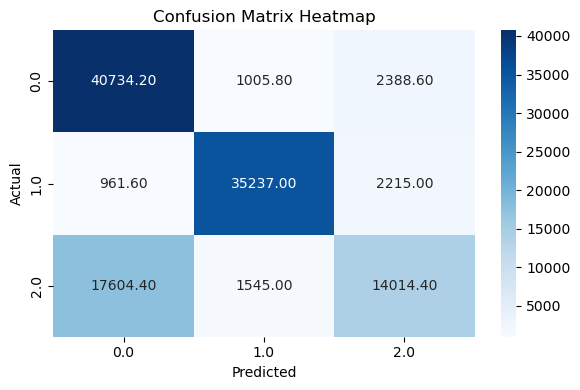

In [36]:
plt.figure(figsize=(6, 4))
sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=confusion_matrix_labels,
            yticklabels=confusion_matrix_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

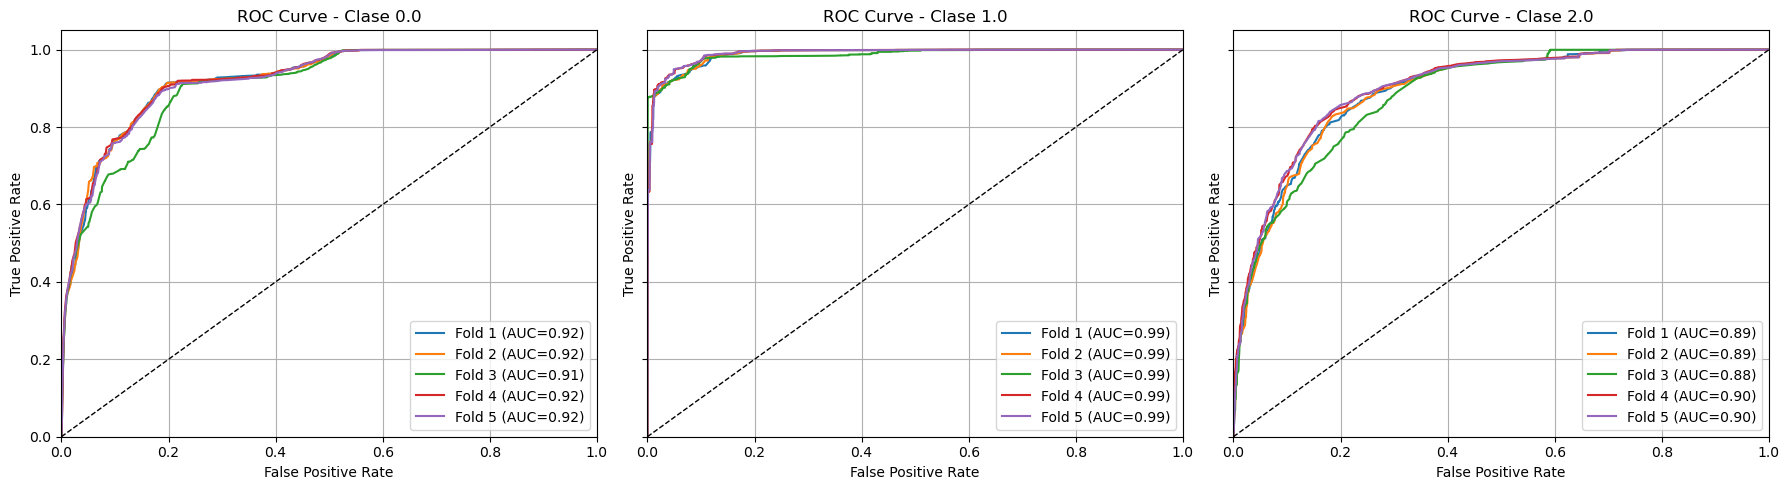

In [37]:
plot_multiclass_roc_all_folds(fold_roc_data, class_labels)

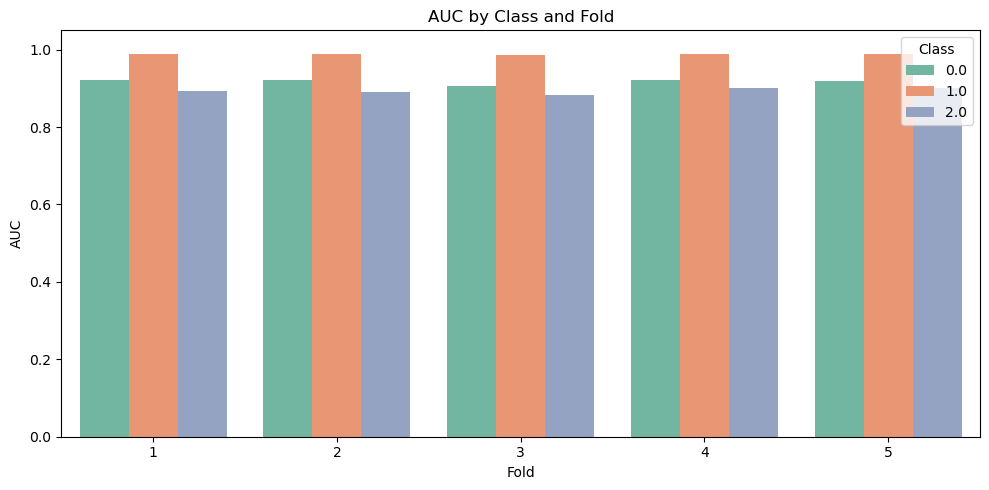

In [38]:
plot_multiclass_auc_bars(fold_auc_scores)

**5.6 Considerations on Data Volume and Sampling in Training**

As discussed in Section 1, K-Fold cross-validation involves training the model ‘k’ times, using in each iteration a considerable subset of the dataset for training (approximately 80% in our case with k=5). While this approach is ideal for obtaining a robust evaluation of model performance, it presents practical challenges when working with large datasets or in environments with limited computational resources—an especially relevant scenario in the context of Big Data Analysis.

During implementation, we faced memory limitations when attempting to load and train the `RandomForestClassifier` model using the full 80% of the dataset for each training fold within the cross-validation loop. Training a complex model repeatedly on such a large data volume (even after the initial sampling step to create sample M) exceeded the available memory capacity in our execution environment (Google Colab with default configurations, or specific local hardware).

To complete the experimentation and obtain an estimate of model performance within the available resources, we decided to apply **additional sampling** inside each iteration of the cross-validation loop, specifically on the training set (`train_df`). As shown in the code, we used 30% of the records from each class per fold.

This adaptation, while **not the standard practice in K-Fold cross-validation** (which ideally uses the full k-1 folds for training), was a **necessary compromise** imposed by memory constraints. By training on a random 30% of the training set in each fold, we significantly reduced the volume of data processed per iteration, allowing the training process to run without exhausting memory resources.

**Implications of this adaptation:**

*   **Feasibility:** It allowed us to carry out cross-validation and obtain evaluable results, fulfilling the activity’s objective of experimenting with and visualizing model performance.
*   **Potential Impact on Results:** Training the model on a smaller subset of data (30% of the training fold instead of 100%) may affect performance estimation. The model may not learn patterns as thoroughly as it would with the full training fold. This could result in slightly lower performance estimates or, potentially, greater variability across folds since each training set is smaller.

We acknowledge that a full evaluation using 80% of the data per fold would provide a more accurate estimate of model performance on a large dataset. However, this adaptation illustrates a common challenge in Big Data handling: the need to adjust standard methodologies (such as full cross-validation) or to use sampling techniques or distributed architectures (such as native Spark MLlib, if the model were available and efficient in its distributed version) in order to operate within resource constraints. In this case, we opted for sampling to allow the experiment to be executed.


**5.7 Summary of Metrics**

In [39]:
results_df = pd.DataFrame(results)
print("\n📊 Summary of metrics per fold:")
print(results_df)
print("\n📈 Averages:")
print(results_df.mean(numeric_only=True))


📊 Summary of metrics per fold:
   Fold  Accuracy  Precision    Recall  F1-Score
0     1  0.783166   0.790234  0.783166  0.771316
1     2  0.781394   0.786933  0.781394  0.769711
2     3  0.763253   0.784792  0.763253  0.741399
3     4  0.781126   0.791572  0.781126  0.764977
4     5  0.779605   0.788957  0.779605  0.764496

📈 Averages:
Fold         3.000000
Accuracy     0.777709
Precision    0.788497
Recall       0.777709
F1-Score     0.762380
dtype: float64


**5.8 Final Supervised Model**

We performed the training of the final model with the hyperparameters already selected through cross-validation.

In [40]:
rf_final = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
    numTrees=10,
    maxDepth=4,
    seed=42
)

model_final = rf_final.fit(df_final)

**5.9 Example of a Prediction**

In [41]:
registry = df_final.orderBy(F.rand()).limit(1)
registry

DataFrame[trip_id: string, trip_hour: string, trip_day_of_week: string, duration_minutes: double, trip_miles: double, tip_per_mile: double, payment_group: string, company_group: string, pickup_zone_group: string, dropoff_zone_group: string, tip_ratio_group: string, trip_hour_idx: double, trip_day_of_week_idx: double, payment_group_idx: double, company_group_idx: double, pickup_zone_group_idx: double, dropoff_zone_group_idx: double, trip_hour_vec: vector, trip_day_of_week_vec: vector, payment_group_vec: vector, company_group_vec: vector, pickup_zone_group_vec: vector, dropoff_zone_group_vec: vector, features: vector, label: double]

In [42]:
prediccion = model_final.transform(registry)
example = prediccion.select("trip_id", "label", "prediction", "features").limit(1)
example.show(truncate=False)

+----------------------------------------+-----+----------+-----------------------------------------------------------------------+
|trip_id                                 |label|prediction|features                                                               |
+----------------------------------------+-----+----------+-----------------------------------------------------------------------+
|b591c93c843d8fa8a83d7e997050679d1811a2c9|1.0  |1.0       |(54,[5,24,33,35,42,46,51],[1.0,1.0,1.0,1.0,1.0,1.0,51.166666666666664])|
+----------------------------------------+-----+----------+-----------------------------------------------------------------------+



## **6. Unsupervised Model: K-Means for Clustering**

**6.1 Training the K-Means model**

In [43]:
kmeans = KMeans(featuresCol="features", k=4, seed=42)
model = kmeans.fit(df_clustering)
predictions = model.transform(df_clustering)

**6.2 Evaluation metrics of the unsupervised model**

In [44]:
evaluator = ClusteringEvaluator(
    featuresCol="features",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

silhouette = evaluator.evaluate(predictions)
wssse = model.summary.trainingCost

print(f"Silhouette Score: {silhouette:.4f}")
print(f"WSSSE (total inertia): {wssse:.2f}")

Silhouette Score: 0.4276
WSSSE (total inertia): 41951499.02


**6.3 Evaluation metrics of the unsupervised model**

In [45]:
print("Cluster distribution:")
predictions.groupBy("prediction").count().orderBy("prediction").show()

Cluster distribution:
+----------+------+
|prediction| count|
+----------+------+
|         0|164642|
|         1| 88479|
|         2|160146|
|         3|166091|
+----------+------+



**6.4 Visualization of Clusters in 2D (using PCA)**

In [ ]:
# Reducing dimensions to 2 for visualization
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(predictions)
pca_result = pca_model.transform(predictions)

# Converting to Pandas for visualization
plot_data = (
    pca_result.select("pca_features", "prediction")
    .rdd.map(lambda row: (
        float(row["pca_features"][0]),  # Converting to native float
        float(row["pca_features"][1]),  # Converting to native float
        int(row["prediction"])         
    ))
    .toDF(["x", "y", "cluster"])
    .toPandas()
)

plt.figure(figsize=(8, 6))
for cluster_id in sorted(plot_data["cluster"].unique()):
    cluster_data = plot_data[plot_data["cluster"] == cluster_id]
    plt.scatter(cluster_data["x"], cluster_data["y"], label=f"Cluster {cluster_id}", alpha=0.6)

plt.title("Visualization of Clusters with PCA (K=4)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

## **7. Visualization of Results**

An analysis of the stability of classification metrics obtained through cross-validation was carried out. Bar plots and boxplots were used to examine variability by fold, and statistical measures (mean and standard deviation) were calculated as a synthesis of the model’s behavior. These metrics allow us to evaluate not only the average performance, but also the consistency of the model across different partitions of the dataset.

**7.1 Initial Configuration of the Visualization Environment**

In [ ]:
# A uniform visual style is defined and the overall figure size is adjusted.
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(12, 6))

# List of key metrics to be evaluated for each fold of the K-Fold Cross-Validation.
metricas = ["Accuracy", "Precision", "Recall", "F1-Score"]

**7.2 Individual Visualization of Metrics per Fold**

In [ ]:
# A bar chart is generated for each metric, showing its value per fold.
# This makes it possible to identify the model’s stability and consistency across partitions.

for metric in metricas:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=results_df, x="Fold", y=metric, palette="Blues_d")
    plt.title(f"{metric} por Fold")
    plt.ylim(0, 1)
    plt.ylabel(metric)
    plt.xlabel("Fold")
    plt.tight_layout()
    plt.show()

**7.3 Boxplot of Metrics for Dispersion Analysis**

In [ ]:
# The boxplot allows visual comparison of the dispersion of metrics across folds,
# Identifying possible outliers or significant variability.

plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df[metricas])
plt.title("Distribution of Metrics by Fold")
plt.ylabel("Value")
plt.xlabel("Metrics")
plt.tight_layout()
plt.show()

**7.4 Calculation of General Statistics**

In [ ]:
# Averages of each metric across all folds,
# Useful for summarizing the overall performance of the model.
print("General Averages of Metrics:")
print(results_df[metricas].mean())

# Standard deviation of each metric, which allows evaluation of model stability.
# Low values indicate consistency across folds; high values suggest significant variability.
print("\nStandard Deviation of Metrics:")
print(results_df[metricas].std())

## **8. Discussion and Conclusion**

## **8.1. Selection of Metrics to Measure Result Quality**

This section presents and justifies the evaluation metrics selected to measure the quality of the results obtained from the models developed during the training stage, both in the context of supervised and unsupervised learning. The correct choice of these metrics is key to ensuring validity, interpretability, and practical usefulness of the models—especially in high-volume data contexts, where even small biases or errors can scale to significant operational impact.

**8.1.1. Supervised Learning Algorithm – Classification with Random Forest**

The task consists of predicting the class **`tip_ratio_group`**, which represents passenger tipping behavior and contains three categories: “Flat Fare Clients,” “Grateful Givers,” and “High-Spirit Donors.”

Selected Metrics:

1.   **Accuracy:** General performance metric, easy to interpret and suitable when classes are balanced through stratified sampling. Implemented as the baseline metric in the previous activity.
2.   **Precisión:** 	Evaluates the correctness of positive predictions per class. Important when false positives need to be avoided (e.g., classifying a user as “High-Spirit Donor” when they are not).
3.   **Recall:** 	Measures the model’s ability to correctly identify all cases of a class. Useful when it is important not to miss relevant cases (e.g., true donors).
4.   **F1-Score:** 	Combines precision and recall, balancing both. Particularly valuable in multiclass problems with classes balanced through sampling, as it avoids the bias introduced by a dominant class.
5.   **Confusion Matrix:** 		Allows inspection of performance class by class, helps understand specific errors, and provides guidance for adjusting the model or class weights if necessary.

These metrics will be calculated on the testing set (`test_df`), derived through stratified sampling, which ensures their validity.

**8.1.2. Unsupervised Learning Algorithm – Clustering with K-Means**

For the clustering model, where no explicit target variable exists, we evaluate the cohesion and separation of the groups generated from the trip features.

Selected Metrics:

1.   **Within Set Sum of Squared Errors (WSSSE):** Also known as inertia, this metric measures the internal compactness of clusters. It is useful for selecting the optimal number of clusters using the elbow method.
2.   **Silhouette Score:** 		Measures cluster separation by considering intra-cluster cohesion and inter-cluster separation. Values close to 1 indicate well-defined clusters. This metric is efficient even with large data volumes.
3.   **Cluster Distribution:** 	Observing the number of records per cluster helps identify extreme imbalances, which may indicate outliers or poor model configuration.

The combined use of these metrics provides a robust and multifaceted evaluation of model performance, aligned with data science best practices and ensuring result reliability in real-world environments. All metrics will be implemented and analyzed during the experimentation phase (Step 4 of the project), providing empirical evidence to the modeling process.

## **8.2. Analysis of Results**

### **8.2.1 Conclusion of the Supervised Learning Analysis**

This section focuses on the critical analysis of the results obtained through the application of a supervised learning model for predicting user profiles according to their tipping behavior in Chicago taxi trips. The target variable (`tip_ratio_group`) was segmented into three customer categories: Flat Fare Clients, Grateful Givers, and High-Spirit Donors, encoded as 0.0, 1.0, and 2.0, respectively.

The quantitative results achieved are satisfactory. The model obtained an overall accuracy of 0.780675, along with a weighted F1-score of 0.765962, indicating an adequate balance between precision and recall for the three classes. Both weighted precision and recall, each close to 0.794028, reinforce this consistency in overall performance, especially considering the potential class imbalance.

The averaged confusion matrix reveals that class 0 (High-Spirit Donors) achieved a high percentage of correct predictions in 92% of cases, while class 1 (Flat Fare Clients) achieved 90% accuracy.

However, class 2.0 (Grateful Givers) shows greater relative confusion. On average, 14,479.6 cases were correctly classified as Grateful Givers, but 1,554.6 were incorrectly assigned to class 1.0, and 17,137.8 to class 0.0. This suggests a slight overlap in behavioral patterns between more generous clients and those with more moderate tipping, possibly due to shared explanatory features such as trip distance, affiliated company, or pickup area.

As an illustration, we present an example of an individual prediction: a trip identified by trip_id = aaac0f63b5c4d999106df9cdddbc47d8c095d77b, with both actual and predicted label equal to 0.0, representing a High-Spirit Donor. This trip is characterized, among other things, by a duration of approximately 1.43 minutes and a distance of 2.098 miles, along with certain encoded categorical variables that influenced the model’s correct prediction.

**Strengths**


*   High predictive performance, even in multiclass classification scenarios.
*   Effective generalization, supported by a low error rate on the testing set.
*   Scalability of the approach, thanks to the use of PySpark, which enables efficient processing of large data volumes.


**Areas for Improvement**


*   Better discrimination for class 2.0, exploring improvements in feature engineering that capture more nuanced aspects of High-Spirit Donor behavior.
*   Search for better hyperparameters using techniques such as GridSearch or RandomSearch.
*   Evaluate the inclusion of more specific temporal variables (such as seasonality or special events) that may impact tipping patterns.
*   Future implementation of techniques like SMOTE or cost-sensitive learning if more pronounced imbalances are identified when expanding the sample.

**Conclusion:**
The trained model demonstrates robust capacity to classify user behavior regarding tipping. Such classification can be key to personalizing loyalty strategies, market segmentation, or even dynamic incentives for drivers and passengers in urban mobility services.

### **8.2.2 Conclusion of the Unsupervised Learning Analysis**

In this section, we examine the results obtained from applying an unsupervised learning algorithm—specifically K-Means with K=4 clusters—on the processed taxi trip dataset. This technique was employed with the objective of identifying natural groupings among trip records without using predefined labels.

**Quantitative Evaluation**
The model achieved a Silhouette Score of 0.4552, indicating moderately high internal cohesion within the clusters formed, as well as reasonable separation between them. This value suggests that the partition generated by the algorithm captures meaningful latent structures in the data, though there remain opportunities to improve the definition of boundaries between some groups.

Additionally, a WSSSE (Within Set Sum of Squared Errors) value of 40,617,944.35 was obtained, representing the total inertia of the model. Although such values tend to be high in large datasets, their main usefulness lies in comparative analysis across different values of K (which could be explored in future iterations using methods such as the Elbow Method).

**Cluster Distribution**

The analysis of record distribution across clusters reveals a highly imbalanced partition:

*   Clúster 0: 149,533 registrys
*   Clúster 1: 74,758 registrys
*   Clúster 2: 218,027 registrys
*   Clúster 3: 135,391 registrys

**Visualization in Reduced Space**

In the figure (Visualization of Clusters with PCA, K=4), a two-dimensional representation of the clusters projected using Principal Component Analysis (PCA) is presented. This dimensionality reduction made it possible to represent the groups in a more interpretable space, facilitating visual inspection of cluster boundaries.

Observations:

*   Clusters 1 (orange) and 3 (red) dominate the dense region of the graph, with clear boundaries in Principal Component 2 for values below -5.
*   Clusters 0 (blue) and 2 (green) exhibit a well-defined boundary across both components.

NOTE: It is important to consider that reducing dimensionality to two principal components may obscure internal patterns present in the data.

**Model Strengths**

* The relatively high Silhouette Score supports a segmentation with internal coherence.
* PCA visualization offers interpretability and spatial evidence of real groupings.
* The model is computationally efficient and scalable, well-suited to large datasets such as in this case.

**Areas for Improvement**

* Perform descriptive profiling for each cluster to identify the most representative variables.
* Analyze results with other values of K to verify whether a larger number of clusters improves granularity without reducing cohesion.
* Explore cluster validation using both internal and external metrics, as well as hierarchical analysis techniques.
* Experiment with PCA visualization in 3 dimensions or with pairs of features.

**Conclusion**
The K-Means model successfully identified relevant latent structures in the data, with reasonable separation between segments. The results are promising for deriving user or trip profiles, and could serve as a foundation for differentiated strategies in service, customer loyalty, or promotional campaigns within urban mobility platforms.